### Notebooks para analizar las métricas de los forecasts - EJECUCIÓN DEV - SOLO UNA EJECUCIÓN

Analizar métricas generadas
INPUTS:
- data train - forecast - predicciones fitten en los datos de train (es solo 1 observación)
- data test - predicciones con un horizonte h

In [1]:
import pandas as pd
import numpy as np

from utils.utils import read_processed_data, set_root_path
from mlforecast import MLForecast
import lightgbm as lgb

from mlforecast.lag_transforms import (
    RollingMean,
    SeasonalRollingMean,
)
from sklearn.metrics import mean_absolute_error

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# set root repo
set_root_path()

root path: /Users/joseortega/Documents/GitHub/vn2_challenge


In [3]:
""" 1. read "processed" data """
# leer archivos "processed" generados en step anterior
param_index_current_week = "2"
param_value_current_date = "2024-04-22"
data, data_state, data_in_stock, data_master, data_submission = (
    read_processed_data(
        week_index=param_index_current_week,
        date_index=param_value_current_date,
    )
)

data processed readed!


In [4]:
""" 2. read data forecast """
# obs: los datos de train y test ya tienen el merge con sus datos de true
folder_forecasts = "data/submission/fcst"

data_fcst_output_train = pd.read_parquet(f"{folder_forecasts}/data_fcst_real_train.parquet")
data_fcst_output_test = pd.read_parquet(f"{folder_forecasts}/data_fcst_real_test.parquet")

In [5]:
data_fcst_output_train.head(3)

,unique_id,ds,y_true,forecast,forecast_int
0,0-126,2021-08-30,5.0,1.219287,1.0
1,0-126,2021-09-06,0.0,1.397843,1.0
2,0-126,2021-09-13,0.0,1.515356,2.0


In [6]:
data_fcst_output_test.head(3)

,unique_id,ds,y_true,forecast,forecast_int
0,0-126,2024-04-29,NaN,0.939071,1.0
1,0-126,2024-05-06,NaN,1.081507,1.0
2,0-126,2024-05-13,NaN,1.017840,1.0


### """ 4. Calcular MAE ponderado por volumen - series con más volumen importan más """
OJO: NO SE DEBE PENALIZAR PORQUE CADA UNIDAD QUE SE PREDIGA MAL, ES UN COSTO ASOCIADO INDEPENDIENTE SI SE VENDE EN PROMEDIO 1000 UNIDADES O 1 UNIDAD

In [7]:
def mae_ponderado_volumen_serie(df_metrics, column_true, column_pred, df_real):
    """
    calcular peso basado en el volumen del real. PERO A NIVEL SERIE
    
    CADA SERIE TIENE SU PROPIO PESO. ASÍ SE EVITA QUE SE BORREN FCST CUANDO EL REAL ES CERO
    SE CALCULA EN BASE A TODA LA DATA PARA EVITAR CEROS
    """
    df_metrics = df_metrics.copy()
    df_real = df_real.copy()


    # calcular peso basado en TOTAL DE HISTORIA
    df_weight = df_real.groupby(["unique_id"])["y"].sum().reset_index()
    df_weight = df_weight.rename(columns = {"y":"y_total"})
    df_weight["weight"] = df_weight['y_total'] / df_weight['y_total'].sum() # CALCULAR PESO
    df_weight = df_weight.drop(columns = "y_total")


    # aplicar peso a fcst
    df_metrics = df_metrics.merge(
        df_weight[["unique_id", "weight"]],
        on="unique_id",
        how="left"
    )

    df_metrics["fcst_weighted"] = df_metrics[column_pred] * df_metrics["weight"]


    # calcular mae
    mae = mean_absolute_error(
        y_true=df_metrics[column_true],
        y_pred=df_metrics["fcst_weighted"],
    )

    return mae

In [8]:
# mae de todos sin aplicar peso
mae_test_int = mean_absolute_error(
    y_true=data_fcst_output_test["y_true"],
    y_pred=data_fcst_output_test["forecast_int"],
)

mae_test_int

ValueError: Input contains NaN.

In [ ]:
# mae ponderado por volumen histórico de todas las series
mae_ponderado_volumen_serie(df_metrics = data_fcst_output_test,
                            df_real = data,
                            column_true = 'y_true',
                            column_pred = 'forecast_int'
                            )

# OJO: CUANDO SE PENALIZA DA UN MAYOR MAE. PERO OJO SE NECESITA A NIVEL SERIE Y SIN PONDERAR POR VOLUMEN, PORQUE PARA OPTIMIZAR COSTOS TODOS LOS PAQUETES PESAN LO MISMO

2.4371952764892186

### 5. calcular métricas para cada serie

In [ ]:
def calcular_mae_serie(df_metrics, features_columns, column_true, column_pred):
    """
    Calcular métrica MAE a nivel serie
    Interesa saber que series tienen más error, independiente si es un volumen alto o bajo
    (ya que cada producto que quede en stock o faltara stock es un costo asociado)
    """
    df_metrics = df_metrics.copy()

    # agrupar
    df_metrics_output = (
        df_metrics
        .groupby(features_columns)
        .apply(lambda g: pd.Series({
            "mae": mean_absolute_error(g[column_true], g[column_pred]),
            "sum_y_true": g[column_true].sum(),
            "mean_y_true": g[column_true].mean(),
        }))
        .reset_index()
    )

    # ordenar de mayor a menor error (todas las series deben predecirse bien)
    df_metrics_output = df_metrics_output.sort_values("mae", ascending=False)

    return df_metrics_output

In [ ]:
# train
mae_serie_train = calcular_mae_serie(df_metrics = data_fcst_output_train, 
                               features_columns = ["unique_id"],
                                column_true = 'y_true',
                                column_pred = 'forecast_int'
                               )
mae_serie_train

/var/folders/fx/0kx46vn52sg544t8x3s4hdl00000gn/T/ipykernel_52777/1876144399.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


,unique_id,mae,sum_y_true,mean_y_true
91,60-126,5.253731,3085.0,23.022388
14,19-103,5.074627,995.0,7.425373
197,61-126,4.858209,2500.0,18.656716
579,64-103,4.440299,1498.0,11.179104
553,63-23,4.119403,6451.0,48.141791
...,...,...,...,...
335,61-292,0.649254,93.0,0.694030
376,61-68,0.641791,90.0,0.671642
311,61-267,0.641791,138.0,1.029851
548,63-213,0.629630,71.0,0.876543


In [ ]:
# test
mae_serie_test = calcular_mae_serie(df_metrics = data_fcst_output_test, 
                               features_columns = ["unique_id"],
                                column_true = 'y_true',
                                column_pred = 'forecast_int'
                               )
mae_serie_test

/var/folders/fx/0kx46vn52sg544t8x3s4hdl00000gn/T/ipykernel_52777/1876144399.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


,unique_id,mae,sum_y_true,mean_y_true
277,61-23,26.333333,312.0,104.000000
553,63-23,23.333333,170.0,56.666667
473,62-23,20.333333,138.0,46.000000
125,60-23,19.333333,157.0,52.333333
530,63-124,15.333333,184.0,61.333333
...,...,...,...,...
171,60-87,0.000000,3.0,1.000000
116,60-210,0.000000,3.0,1.000000
179,61-10,0.000000,3.0,1.000000
424,62-146,0.000000,3.0,1.000000


In [ ]:
mae_serie_test[mae_serie_test["unique_id"] == "61-23"]

,unique_id,mae,sum_y_true,mean_y_true
277,61-23,26.333333,312.0,104.0


### 6. Graficar real vs predicho - TRAIN - SOLO SE FORECASTEA EL SIGUIENTE HORIZONTE h=1

In [9]:
# params
serie_filter = "63-124"
column_true = 'y_true'
column_pred = 'forecast_int'

In [10]:
# filtrar train
df_train_filtered = data_fcst_output_train[data_fcst_output_train["unique_id"] == serie_filter]

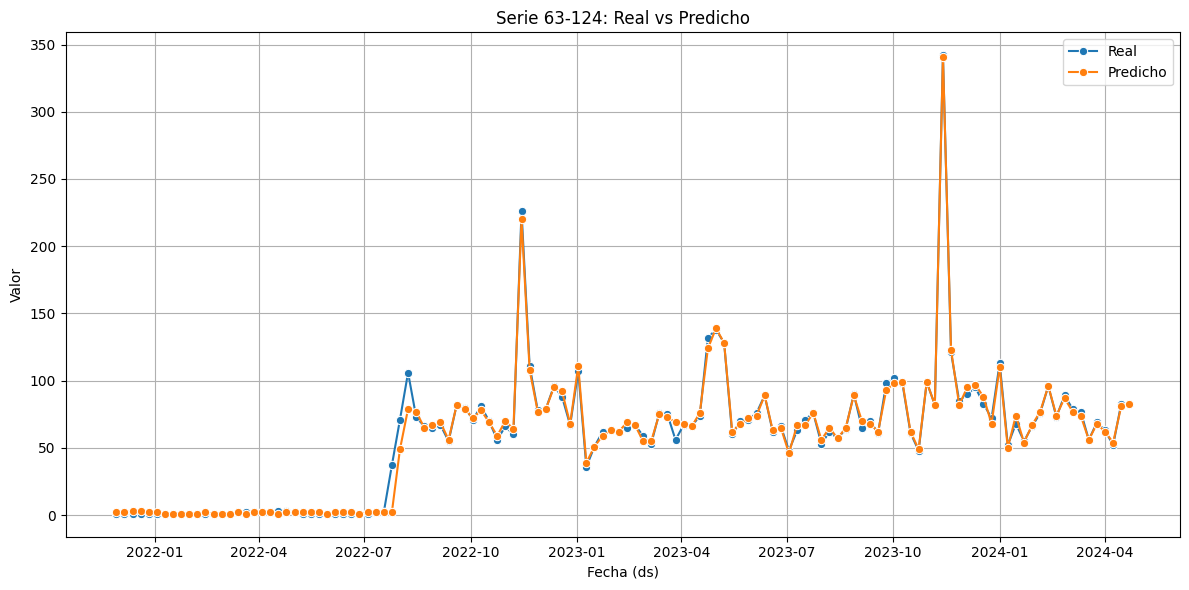

In [11]:
# graficar
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_train_filtered, x="ds", y=column_true, label="Real", marker="o")
sns.lineplot(data=df_train_filtered, x="ds", y=column_pred, label="Predicho", marker="o")

plt.title(f"Serie {serie_filter}: Real vs Predicho")
plt.xlabel("Fecha (ds)")
plt.ylabel("Valor")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### 7. Graficar real vs predicho - TEST - SE FORECASTEA HASTA UN HORIZONTE h=h - SE GENERA POR RECURSIVIDAD

In [12]:
# filtrar test
df_test_filtered = data_fcst_output_test[data_fcst_output_test["unique_id"] == serie_filter]

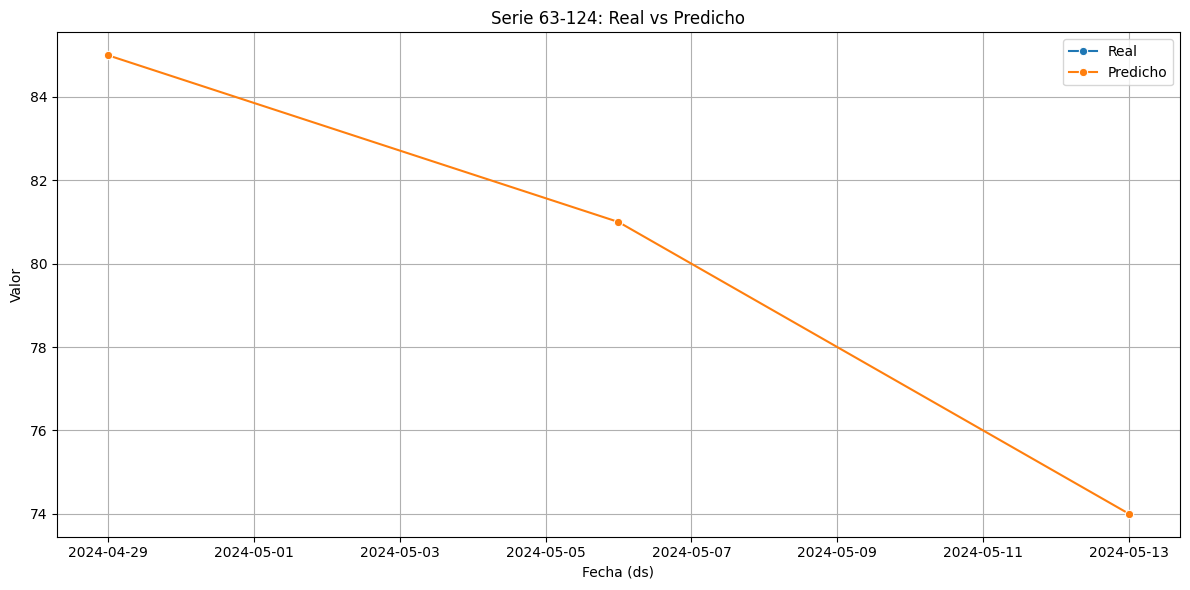

In [13]:
# graficar
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_test_filtered, x="ds", y=column_true, label="Real", marker="o")
sns.lineplot(data=df_test_filtered, x="ds", y=column_pred, label="Predicho", marker="o")

plt.title(f"Serie {serie_filter}: Real vs Predicho")
plt.xlabel("Fecha (ds)")
plt.ylabel("Valor")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

IDEA ANALIZAR INTERPRATIBILIDAD
¿Qué está haciendo este código?
1. Genera datos no lineales → el árbol aprende una función compleja.
2. Selecciona un punto que quieres entender (ej. observación 50).
3. Busca los vecinos más cercanos en el espacio de features.
4. Ajusta una regresión lineal local con las predicciones del árbol como “y”.
5. Obtienes coeficientes locales → cuánto cambia la predicción por unidad de cambio en cada feature, en esa vecindad.
6. Puedes descomponer la predicción en efectos aditivos como si fuera una regresión lineal.

In [25]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt


In [26]:
# ---------------------------------------------------------
# 1️⃣ Creamos datos ficticios
# ---------------------------------------------------------
np.random.seed(42)

n = 200
X = pd.DataFrame({
    "feature1": np.random.uniform(0, 10, n),
    "feature2": np.random.uniform(0, 5, n),
    "feature3": np.random.uniform(0, 100, n),
})

# Verdadero modelo no lineal (desconocido para el analista)
y = (
    3 * np.sin(X["feature1"])
    + 0.5 * X["feature2"]**2
    - 0.1 * X["feature3"]
    + np.random.normal(0, 1, n)
)

In [27]:
X

,feature1,feature2,feature3
0,3.745401,3.210158,10.312387
1,9.507143,0.420700,90.255291
2,7.319939,0.808144,50.525237
3,5.986585,4.492771,82.645747
4,1.560186,3.032145,32.004960
...,...,...,...
195,3.492096,4.653787,47.396164
196,7.259557,4.292064,66.755774
197,8.971103,2.144970,17.231987
198,8.870864,3.754355,19.228902


In [28]:
y

0      1.887717
1     -9.976724
2     -2.250736
3     -0.084134
4      3.842638
         ...   
195    5.755344
196    6.869697
197    3.018631
198    6.433872
199    8.596901
Length: 200, dtype: float64

In [29]:
# ---------------------------------------------------------
# 2️⃣ Entrenamos un modelo no lineal (árbol de decisión)
# ---------------------------------------------------------
tree = DecisionTreeRegressor(max_depth=4, random_state=42)
tree.fit(X, y)

# Predicciones
y_pred = tree.predict(X)

In [30]:
# ---------------------------------------------------------
# 3️⃣ Elegimos un punto para explicar localmente
# ---------------------------------------------------------
i = 50  # el punto que queremos explicar
x0 = X.iloc[[i]]  # mantener formato DataFrame
pred_0 = tree.predict(x0)[0]

print(f"Predicción del modelo para observación {i}: {pred_0:.2f}")

Predicción del modelo para observación 50: -5.29


In [32]:
y[i] # valor real

np.float64(-8.141642543871491)

In [33]:
# ---------------------------------------------------------
# 4️⃣ Seleccionamos vecinos "cercanos" para construir la regresión local
# ---------------------------------------------------------
# Distancia euclídea simple
dist = np.sqrt(((X - x0.values) ** 2).sum(axis=1))
k = 40  # número de vecinos cercanos
neighbors_idx = dist.nsmallest(k).index

local_X = X.iloc[neighbors_idx]
local_y = y_pred[neighbors_idx]  # usamos la predicción del modelo, no el y real

In [35]:
# ---------------------------------------------------------
# 5️⃣ Ajustamos una regresión lineal sobre ese entorno local
# ---------------------------------------------------------
lin = LinearRegression().fit(local_X, local_y)
coefs = pd.Series(lin.coef_, index=local_X.columns)

print("\nCoeficientes locales:")
print(coefs.round(3))

# Predicción local estimada
local_pred = lin.predict(x0)[0]

print(f"\nPredicción local (modelo lineal): {local_pred:.2f}")


Coeficientes locales:
feature1   -0.084
feature2    2.445
feature3   -0.046
dtype: float64

Predicción local (modelo lineal): -5.21


In [39]:
# ---------------------------------------------------------
# 6️⃣ Interpretación
# ---------------------------------------------------------
mean_X = local_X.mean()
base_pred = lin.intercept_ + np.dot(mean_X, lin.coef_)

print("\nDescomposición de la predicción (aproximada):")
for feat in X.columns:
    delta = x0[feat].values[0] - mean_X[feat]
    contrib = delta * coefs[feat]
    print(f"{feat:10s}: Δ{delta:+.2f} × coef {coefs[feat]:+.2f} = {contrib:+.2f}")

print(f"\nBase (promedio local): {base_pred:.2f}")
print(f"Predicción explicada (suma): {base_pred + (local_pred - base_pred):.2f}")
print(f"Predicción árbol real     : {pred_0:.2f}")


Descomposición de la predicción (aproximada):
feature1  : Δ+4.79 × coef -0.08 = -0.40
feature2  : Δ-0.98 × coef +2.44 = -2.40
feature3  : Δ-1.01 × coef -0.05 = +0.05

Base (promedio local): -2.45
Predicción explicada (suma): -5.21
Predicción árbol real     : -5.29


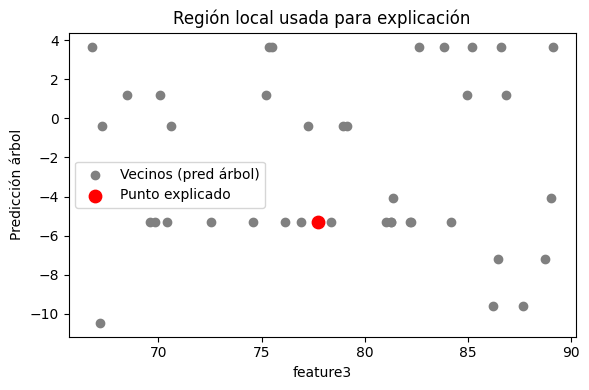

In [40]:
# ---------------------------------------------------------
# 7️⃣ Visual opcional de vecinos
# ---------------------------------------------------------
plt.figure(figsize=(6, 4))
plt.scatter(local_X["feature3"], local_y, color="gray", label="Vecinos (pred árbol)")
plt.scatter(x0["feature3"], pred_0, color="red", s=80, label="Punto explicado")
plt.xlabel("feature3")
plt.ylabel("Predicción árbol")
plt.title("Región local usada para explicación")
plt.legend()
plt.tight_layout()
plt.show()

In [41]:
#“El modelo predijo 12.83 porque, respecto al promedio local (14.17),
#feature3 aumentó 20 unidades → bajó 1.8 puntos,
#feature2 bajó 0.5 → restó 0.5 puntos,
#feature1 subió 2.1 → sumó 1 punto.”